# Estudi del Règim Hidrodinàmic mig i extremal de Portocolom (i sucedanis)
### Treball de Fi de Grau
### Universitat de les Illes Balears
### Grau de Física
### Curs 2023-2024
#### Autor: Marc Uguet Vallbona
#### Tutora: Marta I. Marcos Moreno 

## Apèndix A
A continuació definim funcions simples que ens poden resultar de gran utilitat en el desenvolupament del treball. Sovint són creades per a facilitar la lectura del codi i per a casos molt específics.

Difícilment seran depenents d'altres llibreries i/o funcions. Encara així aprofitam per a importar les llibreries que més sovint farem servir.

In [43]:
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import ListedColormap
import cmocean
import pickle
import icecream as ic


def isiterable(obj):
    """
    Comprova si un objecte és iterable
    :param obj: objecte a comprovar
    :return: True si és iterable, False si no ho és
    """
    try:
        iter(obj)
        return True
    except TypeError:
        return False
    

def lat_lon_depth() -> list:  # TODO: funciona però ho he fet de manera ràpida, crec que se toca poder implementar dins sa funció extractor_dades empleant es parametre 'variables'. REVISAR
    """
    Retorna una llista amb les latituds, longituds i profunditats dels punts de la nostra malla espacial.
    :return: list [lat, lon, depth]
    """    
    path = r"D:\tfg\Data_CoExMed_Balears\1950.mat"
    data_raw = sio.loadmat(path, variable_names=['lat', 'lon', 'depth'])
    
    return [data_raw['lat'][0], data_raw['lon'][0], data_raw['depth'][0]]


def llegir_pkl(path: str) -> dict:
    """
    Llegeix arxius en un fitxer .pkl
    :param path: path del fitxer .pkl
    :return: dades del fitxer .pkl en format diccionari
    """
    import pickle
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

## Apèndix B
Introduïm aqui funcions pròpies de certa complexitat que ens seran d'utilitat més envant.

La funcionalitat, explicació i exemples d'ús de cada funció es troba documentada dins el mateix codi.

In [39]:
def extractor_dades(punts='def', variables='def', anys=range(1950, 2023)) -> dict:
    """
    Llegeix les dades dels punts i variables que li indiquem. El diccionari resultant està ordenat per claus: punt, any, variable.
    Recordem que les dades són horàries i, per tant, cada any conté 8760 valors.
    :param punts: Punt o punts dels quals es volen llegir les dades. 'def' pels 8 punts d'interès, 'tot' per tots els punts. Ha de ser un enter o un objecte iterable d'enters.
    :param variables: Ídem que punts, però per les variables. 'def' per les 5 variables usuals, 'tot' per totes les variables. Ha de ser un string o un objecte iterable de strings.
    :param anys: Anys dels quals es volen llegir les dades.
    :return: dict amb les dades llegides.
    """    
    if punts == 'def':  # punts per defecte
        punts = {'Portocolom': 1366, 'Es Trenc': 1291, 'Port de Sóller': 353, 'Cap Farrutx': 1319,
                 'Men. Nord': 764, 'Men. Sud': 1021, 'Eivissa Est': 912, 'Formentera Sud': 1339}
    elif punts == 'tot':  # tots els punts
        # TODO: fer que també funcioni si es volen llegir tots els punts
        raise NotImplementedError()
    elif not isinstance(punts, (int, list, tuple, dict)):
        # TODO: revisar aquest cas
        raise TypeError('Format no vàlid per a punts. Ha de ser int, list o tuple')

    if variables == 'def':  # variables per defecte
        variables = ('elev_hydro', 'elev_wavedpt', 'Hs_wavedpt', 'Tp_wavedpt', 'Dp_wavedpt')
    elif variables == 'tot':  # totes les variables
        # TODO: fer que també funcioni si es volen llegir totes les variables
        raise NotImplementedError('Encara no s\'ha implementat la lectura de totes les variables')
    elif not isinstance(variables, (str, list, tuple)):
        # TODO: revisar aquest cas
        raise TypeError('Format no vàlid per a variables. Ha de ser str, list o tuple')
    
    data = {}
    for anyi in tqdm(anys, desc='Llegint anys'):
        path = r"D:\tfg\Data_CoExMed_Balears\{}.mat".format(anyi)
        data_raw = sio.loadmat(path, variable_names=variables)

        df_tot = {}
        for key in variables:
            df_tot[key] = pd.DataFrame(data=data_raw[key])

        df_punts = {}
        for key in df_tot.keys():
            df_punts[key] = df_tot[key].iloc[:, list(punts.values())]

        data[anyi] = df_punts

    # posam amb l'ordre desitjat, reformam i retornam
    data_ref = {}
    for kpunt, vpunt in punts.items():
        data_ref[kpunt] = {}
        for var in variables:
            data_ref[kpunt][var] = {}
            for anyi in anys:
                data_ref[kpunt][var][anyi] = list(data[anyi][var][vpunt])

    return data_ref

# COMPROVACIÓ
# dades_1999 = extractor_dades(punts='def', variables='def', anys=[1999])
# print(dades_1999['Portocolom']['elev_hydro'][1999][:10])


def plot_costa(axi, reg=None, lati=None, loni=None, res='h') -> Basemap:
    """
    Pinta la línia de costa de la regió que li indiquem. Si no li indiquem res, pinta la línia de costa de les Illes Balears.
    :param ax: Eix sobre el qual volem pintar la línia de costa.
    :param reg: Regió de la qual volem pintar la línia de costa. Si no s'indica, es pintarà la línia de costa de les Illes Balears.
    :param lati: Latituds de la regió de la qual volem pintar la línia de costa.
    :param loni: Longituds de la regió de la qual volem pintar la línia de costa.
    :param res: Resolució de la línia de costa. 'c' per crude, 'l' per low, 'i' per intermediate, 'h' per high, 'f' per full.
    :return: None
    """
    
    # comprovam que els arguments siguin correctes
    if reg is not None and (lati is not None or loni is not None):
        raise ValueError('No es poden indicar simultàniament regió i latitud/longitud')
    if reg is None and (lati is None or loni is None):
        raise ValueError('S\'ha d\'indicar regió o latitud/longitud')
    regions_permeses = ('IB', 'MALL', 'MEN', 'EIV', 'FOR', 'MALL_MEN', 'PITI', 'TEST')
    if reg is not None:
        if not isinstance(reg, str):
            raise TypeError('El nom de la regió ha de ser un string. Els valors permesos són: IB, MALL, MEN, EIV, FOR, MALL_MEN, PITI o TEST')
        reg = reg.upper()
        if reg not in regions_permeses:
            raise ValueError('El nom de la regió no és vàlid. Els valors permesos són: IB, MALL, MEN, EIV, FOR, MALL_MEN, PITI o TEST')
        elif reg == 'IB':
            lati = [38.5, 40.5]
            loni = [1., 4.5]
        elif reg == 'MALL':
            lati = [39.2, 40.2]
            loni = [2.5, 4.5]
        # TODO: completar la resta de regions
    if lati is not None and loni is not None:
        if not isiterable(lati) or not isiterable(loni):
            raise TypeError('lat i lon han de ser objectes iterables')
        if len(lati) < 2 or len(loni) < 2:
            raise ValueError('lat i lon han de tenir com a mínim 2 valors')
    
    m = Basemap(projection='mill', llcrnrlat=min(lati), urcrnrlat=max(lati), llcrnrlon=min(loni), urcrnrlon=max(loni), resolution=res, ax=axi)
    m.drawcoastlines()
    
    return m

# COMPROVACIÓ
# import matplotlib.pyplot as plt
# plot_costa('IB')
# plt.show()


def crear_percentils(var_names = None, punts = None, full_time_series = False) -> None:
    """
    Crea un fitxer .pkl amb els percentils de les variables d'interès per a tots els punts.
    :param var_names: Noms de les variables d'interès. Per defecte ('elev_hydro', 'elev_wavedpt', 'Hs_wavedpt', 'Tp_wavedpt', 'Dp_wavedpt').
    :param punts: Punts espacials dels quals es volen calcular els percentils. Per defecte els 8 punts d'interès.
    :return: 
    """
    # demanam a l'usuari si vol executar la funció ja que pot trigar molt
    res = input('Aquesta funció pot tardar molt. Vols continuar? (s/[n])')
    if res not in ('s', 'S'):
        return
    
    if var_names is None:
        var_names = ('elev_hydro', 'elev_wavedpt', 'Hs_wavedpt', 'Tp_wavedpt', 'Dp_wavedpt')
    elif not isiterable(var_names):
        raise TypeError('var_names ha de ser un objecte iterable tot i que sigui d\'un sol element. Ex.: ("elev_hydro",) o ["elev_hydro"]')
    
    if punts is None:
        punts = [353, 764, 912, 1021, 1291, 1319, 1339, 1366]
    elif punts == 'tot':
        punts = list(range(0, np.shape(sio.loadmat(r"D:\tfg\Data_CoExMed_Balears\1950.mat")['lat'])[1]))
    elif not isiterable(punts):
        raise TypeError('punts ha de ser un objecte iterable tot i que sigui d\'un sol element. Ex.: (353,) o [353]')
    
    if full_time_series:
        if len(var_names) > 1:
            raise Exception('Si es vol calcular la sèrie temporal completa, només es pot calcular una variable a la vegada per evitar que el càlcul sigui massa llarg.')
    
    percentils_res = {}
    for year in tqdm(range(1950, 2023), desc='Càlcul percentils per any'):
        data_raw = sio.loadmat(r"D:\tfg\Data_CoExMed_Balears\{}.mat".format(year), variable_names=var_names)
        # cream diccionari de dataframes
        df = {}
        for key in var_names:
            df[key] = pd.DataFrame(data=data_raw[key])
        # ens quedam només amb les columnes (punts espacials) d'interès
        df_punts = {}
        for key in df.keys():
            df_punts[key] = df[key].iloc[:, punts]
        # calculam els percentils
        percentils_i = {}
        for key in df_punts.keys():
            percentils_i[key] = df_punts[key].quantile(q=[0.5, 0.95, 0.99], axis=0)
        # guardam dins un dict
        percentils_res[year] = percentils_i

    # guardam sa variable percentils en format .py
    res = input('Vols guardar els percentils en un fitxer .pkl? (s/[n])')
    if res in ('s', 'S'):
        nom_arxiu = input('Nom de l\'arxiu ("percentils" per defecte) (sense extensió): ') # TODO: comprovar que això funcioni
        if nom_arxiu == '':
            nom_arxiu = 'percentils'
        with open(r"D:\tfg\{}.pkl".format(nom_arxiu), 'wb') as f:
            pickle.dump(percentils_res, f)

# COMPROVACIÓ
# crear_percentils()

## 0. Dades i metodologia
Les dades estan ubicades dins una carpeta (*path*) amb arxius .mat separats per anys. Des del 1950.mat el 2022.mat.  

## 1. Primer tractament de les dades.
### Visualització dels punts de malla sobre un mapa de les Illes Balears
Procedirem a la creació de diversos mapes de les Illes Balears amb els punts de malla que hem extret de les dades. La intenció és representar-hi amb diferents colormaps les diferents magnituts que se'n puguin extreure de les dades.

Com a primer contacte amb les dades, hi mostrarem la profunditat dels punts de malla.

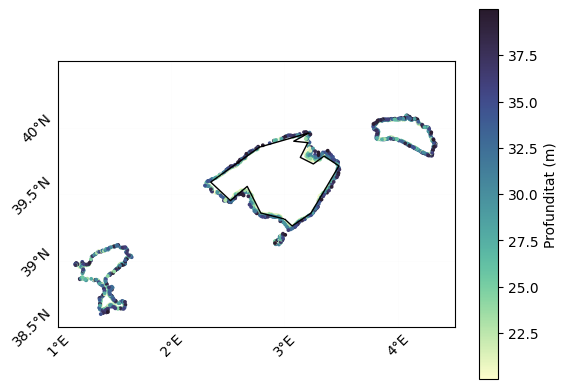

In [47]:
lat, lon, depth = lat_lon_depth()  # extreim les dades

# ara llegirem el colormap que volem
rgb = np.loadtxt(r"D:\tfg\cmocean_phase.rgb") / 255  # normalitzam els valors
cmocean_phase = ListedColormap(rgb)

fig, ax = plt.subplots()
m = plot_costa(axi = ax, reg='IB', res='l')
parallels = np.arange(38.5, 40.6, 0.5)
m.drawparallels(parallels, linewidth=.01, labels=[True,False,False,False], rotation=45)
meridians = np.arange(1.,4.6,1)
m.drawmeridians(meridians, linewidth=.01,labels=[True,False,False,True], rotation=45)
sc = m.scatter(lon, lat, latlon=True, c=depth, cmap=cmocean.cm.deep, s=3)
plt.colorbar(sc, label='Profunditat (m)')
plt.show()

## 2. Anàlisi. Estudi del comportament de les variables durant tota la sèrie temporal.

### 2.1. Direcció de l'onatge
En primer lloc, volem estudiar la direcció de l'onatge per a veure d'on prové l'onatge a cada punt de malla majoritàriament.

## 3. Anàlisi de les dades. Càlcul i representació de percentils d'interès.
A n'aquest apartat farem ús de les funcions crea_percentils i llegir_pkl per a calcular i llegir els percentils de les variables d'interès.

In [45]:
path = r"D:\tfg\percentils.pkl"
try:
    percentils = llegir_pkl(path)
except FileNotFoundError:
    crear_percentils()
    percentils = llegir_pkl(path)

# el format de percentils és: any -> variable -> punt -> percentil
# ex.: p95_75_elevhydro_soller = percentils[1975]['elev_hydro'][353][0.95]
print(percentils)

{1950: {'elev_hydro':           353       764       912       1021      1291      1319      1339  \
0.50  0.000854  0.000121  0.002968 -0.000064  0.001704 -0.000022  0.002972   
0.95  0.119147  0.120983  0.116762  0.119303  0.117924  0.122153  0.115075   
0.99  0.198064  0.210010  0.188160  0.207109  0.192253  0.213423  0.182080   

          1366  
0.50  0.000485  
0.95  0.119436  
0.99  0.196696  , 'elev_wavedpt':           353       764       912       1021      1291      1319      1339  \
0.50  0.007950  0.007926  0.009775  0.008065  0.008927  0.006455  0.010406   
0.95  0.115575  0.118833  0.114097  0.119699  0.114995  0.116563  0.113066   
0.99  0.190156  0.199084  0.178508  0.193997  0.183391  0.200420  0.171996   

          1366  
0.50  0.007854  
0.95  0.115552  
0.99  0.186314  , 'Hs_wavedpt':           353       764       912       1021      1291      1319      1339  \
0.50  0.491033  0.663531  0.623724  0.448380  0.463483  0.649227  0.625416   
0.95  1.914874  2.606936  1.

Una vegada tenim les dades per mà, podem començar amb les representacions gràfiques.

En primer lloc començariem amb un mapa de les balears on hi mostrarem el percentil 50 (mediana) de la direcció de l'onatge per a cada punt de malla.